# 確率ロボティクス 2021年度 課題
拡張カルマンフィルタを用いた自己位置推定のアルゴリズムをシミュレーションする．

In [1]:
# インポート
import matplotlib.pyplot as plt
import numpy as np
import math

In [34]:
class Robot:
    def __init__(self, x, y, th):
        #self.actual_pose = [np.array([x, y, th])]
        #self.pose = [np.array([x, y, th])]
        self.dt = 0.01
        self.xt = np.array([x, y, th])
        self.actual_xt = np.array([x, y, th])
        
    def updateRobotPos(self, vt, wt): 
        theta = self.xt[2]
        dxt = np.array([-vt / wt * math.sin(theta) + vt / wt * math.sin(theta + wt * self.dt), vt/wt*math.cos(theta)-vt/wt*math.cos(theta+wt*self.dt), wt*self.dt])
        self.xt = self.xt + dxt

        #vtt = vt * 1.1
        #wtt = wt * 1.1
        vtt = vt + np.random.normal(loc=0, scale=1)
        wtt = wt + np.random.normal(loc=0, scale=1)
        actual_theta = self.actual_xt[2]
        actual_dxt = np.array([-vtt / wtt * math.sin(actual_theta) + vtt / wtt * math.sin(actual_theta + wtt * self.dt), vtt/wtt*math.cos(actual_theta)-vtt/wtt*math.cos(actual_theta+wtt*self.dt), wtt*self.dt])
        self.actual_xt = self.actual_xt + actual_dxt

In [45]:
def plot(robot, actual_robot, estimate_robot, m):
    fig = plt.figure(figsize=(10, 10))
    world = fig.add_subplot(1,1,1)
    world.set_xlim(-1.0,1.0)
    world.set_ylim(-0.5,1.5)

    plt.scatter(m[0], m[1], s=100, marker="*", color="red")
    
    xs = [0]
    ys = [0]
    vxs = [0]
    vys = [0]
    for r in robot:
        xs.append(r[0][0])
        ys.append(r[0][1])
        vxs.append(math.cos(r[0][2]))
        vys.append(math.sin(r[0][2]))
        
    plt.quiver(xs, ys, vxs, vys, color="gray", alpha = 0.2)
    
    xs = [0]
    ys = [0]
    vxs = [0]
    vys = [0]
    for r in actual_robot:
        xs.append(r[0][0])
        ys.append(r[0][1])
        vxs.append(math.cos(r[0][2]))
        vys.append(math.sin(r[0][2]))
        #print(xs)
        
    plt.quiver(xs, ys, vxs, vys, color="green", alpha = 0.5)
    
    xs = []
    ys = []
    vxs = []
    vys = []
    for r in estimate_robot:
        xs.append(r[0][0])
        ys.append(r[1][0])
        vxs.append(math.cos(r[2][0]))
        vys.append(math.sin(r[2][0]))
        #print(xs)
        
    plt.quiver(xs, ys, vxs, vys, color="red", alpha = 1.0)

    plt.show()

In [46]:
def ekf(mu_t1, sigma_t1, ut, zt, ct, m):
    dt = 0.01
    alpha = np.array([0.1, 0.1, 0.1, 0.1])
    sigma_r = 0.01
    sigma_phai = 0.5
    sigma_s = 0.1
    
    theta = mu_t1[2];
    vt = ut[0];
    wt = ut[1];
    
    Gt = np.array([[1, 0, (-vt/wt)*math.cos(theta) + (vt/wt)*math.cos(theta+wt*dt)], [0, 1, (-vt/wt)*math.sin(theta) + (vt/wt)*math.sin(theta+wt*dt)], [0, 0, 1]])
    Vt = np.array([[(-math.sin(theta)+math.sin(theta+wt*dt))/wt,  vt*(math.sin(theta)-math.sin(theta+wt*dt))/(wt^2)+vt*math.cos(theta+wt*dt)*dt/wt],
          [(math.cos(theta)-math.cos(theta+wt*dt))/wt, -vt*(math.cos(theta)-math.cos(theta+wt*dt))/(wt^2)+vt*math.sin(theta+wt*dt)*dt/wt],
          [0, dt]])
    Mt = np.array([[alpha[0] * vt**2 + alpha[1] * wt**2, 0],
          [0, alpha[2] * vt**2 + alpha[3] * wt**2]])
    mu_tb = mu_t1 + np.array([[(-vt/wt)*math.sin(theta) + (vt/wt)*math.sin(theta+wt*dt)], [(vt/wt)*math.cos(theta) - (vt/wt)*math.cos(theta+wt*dt)], [wt*dt]])
    sigma_tb = Gt.dot(sigma_t1).dot(Gt.T) + Vt.dot(Mt).dot(Vt.T)
    Qt = np.array([[sigma_r**2, 0, 0], [0, sigma_phai**2, 0], [0, 0, sigma_s**2]])
    
    q = (m[0]-mu_tb[0][0])**2 + (m[1]-mu_tb[1][0])**2
    zth = np.array([[math.sqrt(q)], [math.atan2(m[1]-mu_tb[1][0], m[0]-mu_tb[0][0]) - mu_tb[2][0]], [0]])
    Ht = np.array([[-(m[0] - mu_tb[0][0]) / math.sqrt(q), -(m[1] - mu_tb[1][0]) / math.sqrt(q), 0], [(m[1] - mu_tb[1][0]) / q, -(m[0] - mu_tb[0][0]) / q, -1], [0, 0, 0]])
    St = Ht.dot(sigma_tb).dot(Ht.T) + Qt
    Kt = sigma_tb.dot(Ht.T).dot(np.linalg.inv(St))
    mu_tb = mu_tb + Kt.dot((zt - zth))
    sigma_tb = (np.eye(3) - Kt.dot(Ht)).dot(sigma_tb) 

    mu_t = mu_tb
    sigma_t = sigma_tb
    pzt = 0
    
    return mu_t, sigma_t, pzt

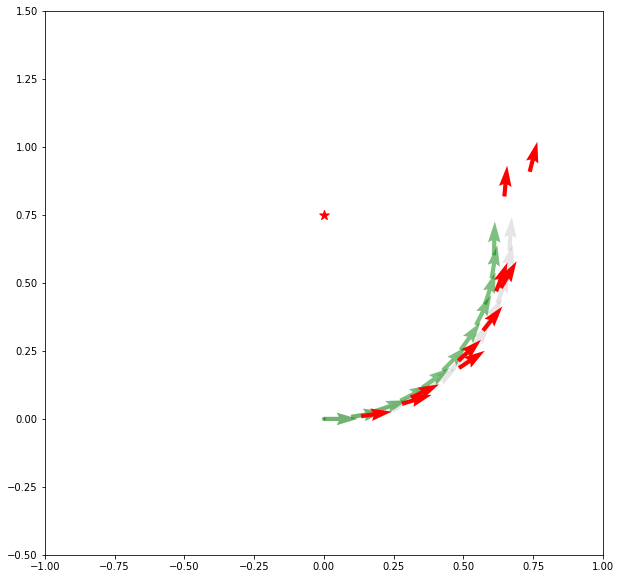

In [48]:
robot = Robot(0, 0, 0)
store_robot = [np.array([robot.xt])]
store_actual_robot = [np.array([robot.actual_xt])]
store_estimate_robot = []
m = np.array([0, 0.75])

mu_t = np.array([[robot.xt[0]], [robot.xt[1]], [robot.xt[2]]])
sigma_t = np.array([[0.001**2,0,0], [0,0.001**2,0],[0,0,0.01**2]])


mu_t1 = mu_t
sigma_t1 = sigma_t
ut = np.array([10, 15])
ct = 1
for i in range(0, 10):
    #### 移動 ####
    robot.updateRobotPos(ut[0], ut[1])
    store_robot.append(np.array([robot.xt]))
    store_actual_robot.append(np.array([robot.actual_xt]))
    
    #### 観測 ####
    z = m - np.array([robot.actual_xt[0], robot.actual_xt[1]])
    zt = np.array([[math.sqrt(z[0]**2+z[1]**2)], [math.atan2(z[1], z[0] - robot.actual_xt[2])], [0]])
    
    #### カルマンフィルタ #####
    mu_t1 = mu_t
    sigma_t1 = sigma_t
    mu_t, sigma_t, pzt = ekf(mu_t1, sigma_t1, ut, zt, ct, m)
    store_estimate_robot.append(mu_t)
    
#for r in store_estimate_robot:   
    #print(r[1])
    
#print(store_robot)
plot(store_robot, store_actual_robot, store_estimate_robot, m)